### «Статистический анализ данных сервиса аренды самокатов для отдела маркетинга компании GoFast .  »

**Постановка задачи:** 

Заказчик этого исследования — сервис по прокату самокатов GoFast. Нам нужно изучить и проанализировать данные о некоторых пользователях из нескольких городов, которые совершают поездки с использованием сервиса GoFast. На основании этих данных необходимо проверить несколько гипотез о времени поездок, расстоянии, помесячной выручке, и влияние технических обновлений, а также необходимо определить минимальное число промокодов для достижения плана и построить график распределения для оценки открытия push-уведомлений. Исходные данные: данные, предоставленные сервисом GoFast. Набор данных содержит информацию о пользователях, поездках и подписках на сам сервис.

**Ход исследования**
1. Загрузим и предварительно проанализируем данные.
2. Опишем данные.
3. Проведём исследовательский анализ данных.
4. Подсчёт выручки: расчет помесячной выручки для каждого пользователя
5. Выдвинем и проверким статистические гипотезы о "выгодности" пользователей с подпиской.






Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**без подписки**
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra**
-  абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

In [49]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom

## 1. Загрузка данных

In [2]:
rides = pd.read_csv('/datasets/статистика проект/rides_go.csv')
subs = pd.read_csv('/datasets/статистика проект/subscriptions_go.csv')
users = pd.read_csv('/datasets/статистика проект/users_go.csv')

In [3]:
# Используем готовую функцию и посмотрим на данные, сделав базовую предобработку.
def brief_df (df):
    df.info()
    print('-'*60)
    # стилизуем названия колонок
    df.columns = df.columns.str.replace(' ','_').str.lower()
        # Подсчитываем пустые значения и уникальные значение
    rows_na = df.isna().sum().reset_index().rename(columns={0: "valuesNa"})
    rows_notna = df.notna().sum().reset_index().rename(columns={0: "valuesNotNa"})
    rows_analysis = pd.merge(rows_na, rows_notna, on="index", how= "outer")
    rows_analysis["completeRatio"] = round((rows_analysis["valuesNotNa"]) / (rows_analysis["valuesNotNa"]+rows_analysis["valuesNa"])*100,2)
    
    cardinality = df.nunique().reset_index().rename(columns={0: "Nunique"})
    rows_analysis = pd.merge(rows_analysis, cardinality)
    
    # Размер датасета и кол-во дубликатов
    
    print("Размер:", df.shape)
    dup_raw = df.duplicated ().sum()
    dup_per = round((dup_raw*100)/df.shape[0],2)
    print('-'*60)
    print ("Дубликаты количество:",dup_raw, '   Процент дубликатов :',  dup_per, "%")
    
    # Статистика по пустым значениям
    print('-'*60)
    print()
    print()
    print("Проверка на пропущенные значениия.")
    display(rows_analysis)
    
    # Первые пять строк
    print('-'*60)
    print()
    print("Первые пять строк.")
    display(df.head())
    print('-'*60)
    print()
    print('Описательная функция desribe.')
    display(df.describe())
    return df  

In [4]:
brief_df(rides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
------------------------------------------------------------
Размер: (18068, 4)
------------------------------------------------------------
Дубликаты количество: 0    Процент дубликатов : 0.0 %
------------------------------------------------------------


Проверка на пропущенные значениия.


,index,valuesNa,valuesNotNa,completeRatio,Nunique
0,user_id,0,18068,100.0,1534
1,distance,0,18068,100.0,18068
2,duration,0,18068,100.0,17974
3,date,0,18068,100.0,364


------------------------------------------------------------

Первые пять строк.


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


------------------------------------------------------------

Описательная функция desribe.


,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


In [5]:
# Перед визуализацией зададим размер шрфита для тиков.
plt.rcParams['xtick.labelsize'] = 9  # Ось X
plt.rcParams['ytick.labelsize'] = 9 # Ось Y

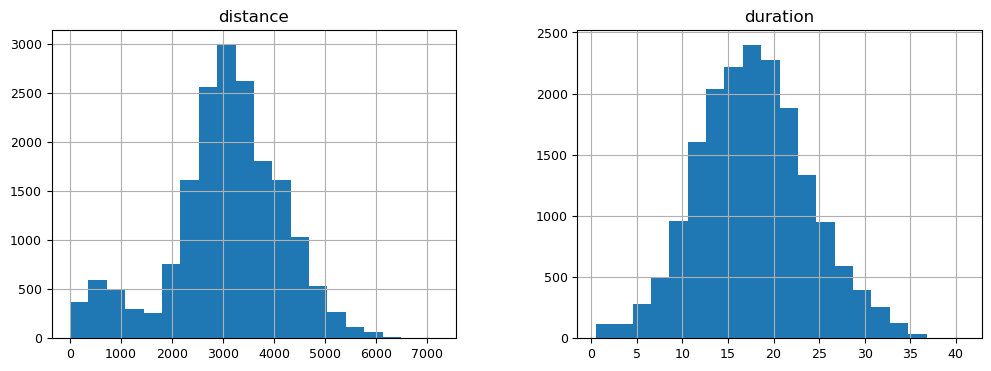

In [6]:
# Посмотрим на распределение числовых колонок.
rides[['distance','duration',]].hist(figsize=(12,4),bins = 20)
plt.show()

In [7]:
print('Начало периода наблюдений' , rides.date.min())
print('Последняя дата наблюдений', rides.date.max())


Начало периода наблюдений 2021-01-01
Последняя дата наблюдений 2021-12-30


**Выводы по датасету rides**

- Датасет чистый. В нём нет явных дубликатов, пропущенных или аномальных значений.
- Всего 18069 наблюдений.
- Количество уникальных пользователей составляет 1534.
- Значения в колонках "время поездки" и "дистанция" соотвествуют нормальному распределению. В колонке дистанция есть маловыраженный пик в районе 500 метров и пик в области 3000 метров. Центр набора данных в колонке "время поездки" находится в области 17 минут и имеет форму колоколообразной кривой. 
- Наблюдений осуществлялись 364 дня, за весь 2021 год.
- Колонка с датой не соотвествует необходимому типу, которую следует изменить.

In [8]:
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Выводы по датасету rides**
- Тарифы за поездки соотвествуют заявленным.

In [9]:
brief_df(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
------------------------------------------------------------
Размер: (1565, 5)
------------------------------------------------------------
Дубликаты количество: 31    Процент дубликатов : 1.98 %
------------------------------------------------------------


Проверка на пропущенные значениия.


,index,valuesNa,valuesNotNa,completeRatio,Nunique
0,user_id,0,1565,100.0,1534
1,name,0,1565,100.0,194
2,age,0,1565,100.0,29
3,city,0,1565,100.0,8
4,subscription_type,0,1565,100.0,2


------------------------------------------------------------

Первые пять строк.


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


------------------------------------------------------------

Описательная функция desribe.


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


In [10]:
# Посмотрим на дубликаты.
users[users.duplicated(keep=False)].sort_values('name').head(16)

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
292,293,Агата,26,Краснодар,ultra
1545,807,Александр,28,Екатеринбург,free
806,807,Александр,28,Екатеринбург,free
1553,121,Алина,25,Пятигорск,ultra
120,121,Алина,25,Пятигорск,ultra
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1559,209,Андрей,23,Омск,ultra
208,209,Андрей,23,Омск,ultra


В датасете users 31 явных дубликата от которых мы избавимся.

In [11]:
users = users.drop_duplicates()

<Axes: >

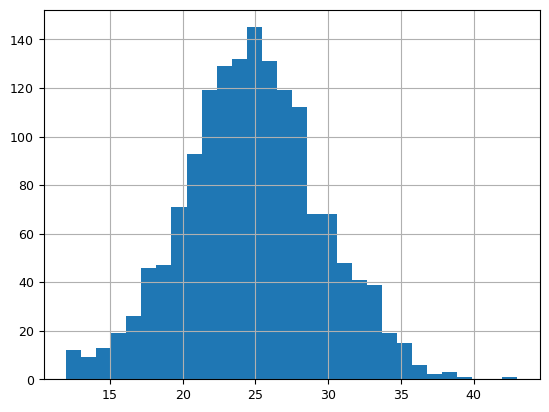

In [12]:
# Построим простой график для колонки "возраст" и посмотрим как распределены данные.
users.age.hist(bins=30)

In [13]:
print(f'Средний возраст составляет {int(users.age.mean().round())} лет')

Средний возраст составляет 25 лет


In [14]:
# Посмотрим на уникальные значения колонок с именами пользователей.
users.name.unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [15]:
# Посмотрим на города.
users.city.unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [16]:
print('Количество представленных городов:', len(users.city.unique()))

Количество представленных городов: 8


**Выводы по колонке users**
- Количество уникальных пользователей в базе с зарегистрированными пользователями соотвествует количеству уникальных пользователей датасета "поездки".
- В датасете 31 явный дубликат.
- Колонка "возраст" имеет нормальное распределение, без аномальных значений, с центром набора данных в районе 25ти лет.
- Средний возраст пользователей составляет 25 лет. 
- Всего представлено 8 городов России : Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'.

## 2. Предобработка данных

In [17]:
# Приводим тип колонки с датой к нужному типу.
rides['date'] = pd.to_datetime(rides.date)

In [18]:
# Добавляем колонку с месяцем.
rides['month'] = rides.date.dt.month

In [19]:
rides

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


## 3. Исследовательский анализ данных

3.1  Частота встречаемости городов

In [20]:
# Создадим переменную с частотой встречаемости городов.
bar_city =  users.city.value_counts().sort_values(ascending=False)

In [21]:
bar_city.sort_values(ascending=False)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

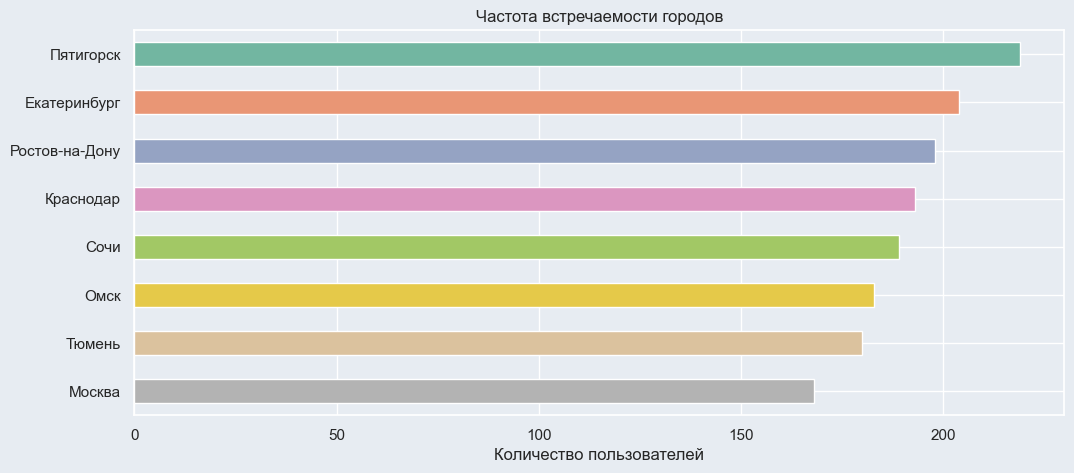

In [22]:
# Визуализируем
sns.set(rc={'axes.facecolor':'#e7ecf2', 'figure.facecolor':'#e7ecf2'})
plt.figure(figsize=(12,5))
ax = sns.barplot(x=bar_city,y=bar_city.index,width=0.5,palette='Set2')
plt.grid(axis='y',lw=1)
plt.title('Частота встречаемости городов')
plt.ylabel('')
plt.xlabel('Количество пользователей')
plt.show()

- Наибольшее количество пользователей приходится на Пятигорск. В нём зарегистрировано 219 пользователей. В тройку входят Екатеринбург(204) и Ростов-на-Дону(198).
- Чарт замыкает город Москва с 168 зарегистрированными пользователями.

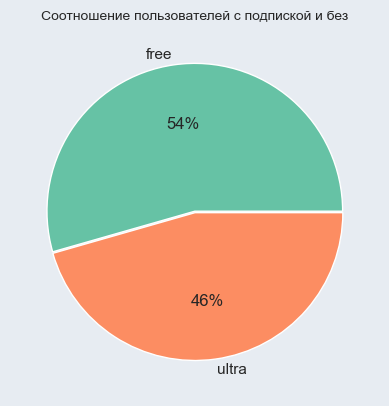

In [23]:
# Посмотрим на распределение долей для пользователей с подпиской и без.
grade_pie = users.groupby('subscription_type')['user_id'].count()
plt.rcParams['figure.dpi'] = 100
palette_color = sns.color_palette('Set2')
plt.pie(grade_pie.values,
        labels = grade_pie.index,
        colors = palette_color,
        autopct = '%.0f%%',
        labeldistance = 1.07,
        explode = (0,0.01))
plt.title("Соотношение пользователей с подпиской и без", fontsize = 10)

plt.show();

- Доля пользователей с платной подпиской состаляет 46% от общего.

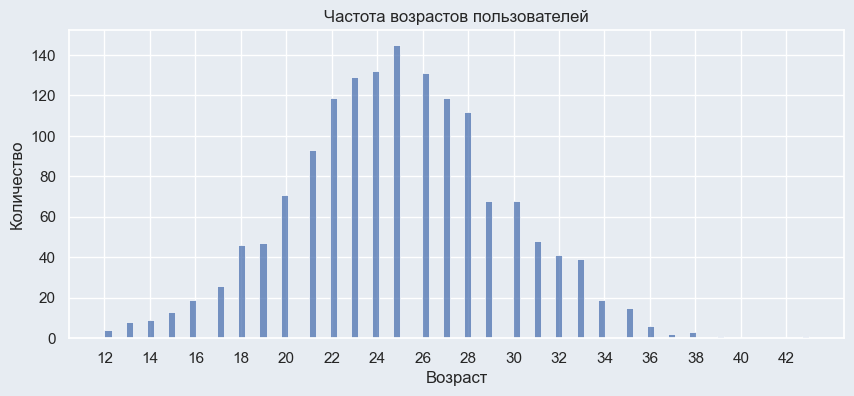

In [24]:
plt.figure(figsize=(10,4))

sns.histplot(users['age'], bins=100)
plt.title('Частота возрастов пользователей')

plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.xticks(range(12,44,2))
plt.show()

In [25]:
users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

- Средний возраст пользователей сервиса составляет 25 лет.
- Около 70% всех пользователей имеют возраст от 20 до 30 лет.
- Дети возрастом менее 12 лет не пользуется сервисом, как и взрослые старше 42х лет.

In [26]:
rides

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


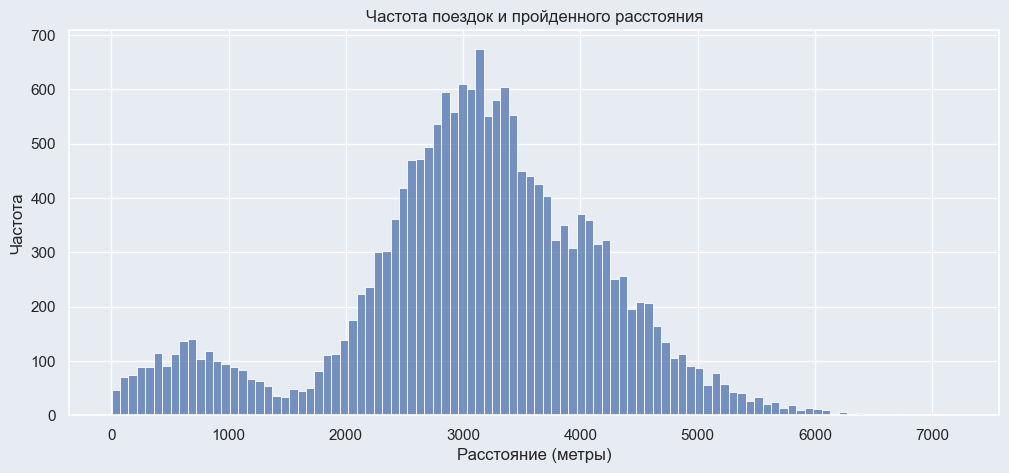

In [27]:
plt.figure(figsize=(12,5))

sns.histplot(rides['distance'], bins=100)
plt.title('Частота поездок и пройденного расстояния')

plt.xlabel('Расстояние (метры)')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

In [28]:
print('Средняя составляет:',rides['distance'].mean())
print('Медиана составляет:',rides['distance'].median())

Средняя составляет: 3070.6599756818814
Медиана составляет: 3133.6099936787664


- На графике есть небольшой пик в области 500 метров, а так же значительный пик в области 3000 метров, что , скорее всего, говорит о разных целях использования транспортных средств. В первом случае самокатом могут пользоваться для поездки до метро, дома, другого вида транспорта, а второй  в развлекательных целях.

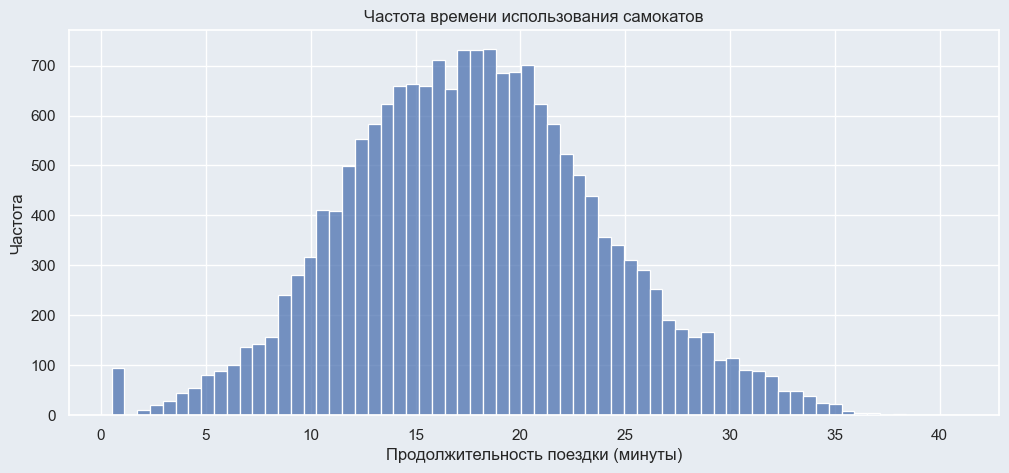

In [29]:
plt.figure(figsize=(12,5))
sns.histplot(rides['duration'])
plt.title('Частота времени использования самокатов')
plt.xlabel('Продолжительность поездки (минуты)')
plt.ylabel('Частота')
plt.show()

In [30]:
# Посмотрим на наличие аномально коротких заездов.
rides[rides['duration'] <= 2]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [31]:
print('Доля неудачных поездок составляет', round((len(rides[rides['duration'] <= 2])/len(rides) *100),2), 'процента')

Доля неудачных поездок составляет 0.53 процента


- В датасете с поездками 95 аномально коротких заезда, что составляет около половина процента от общего. При этом во всех случаях пройдена внушительная дистанция, невозможная с учётом технических характеристик транспортного средства. Причина может быть как в сбое системы слежения и навигации, так и устройства отсчёта времени поездки.

- Более 70% всех пользователей сервиса катается от 12 до 23 минут.
- Средняя продолжительность поездки равна 17 с половиной минутам.
- Доля неудачных поездок, которые продлились менее минуты составлиа 0.53 процента от общих.

In [32]:
# Добавил колонку со скоростью и посмотрим есть ли другии аномально быстрые поездки.
rides['speed'] = rides['distance']/rides['duration'] 

In [33]:
rides['speed'].describe()

count    18068.000000
mean       229.754352
std        735.936479
min          0.085552
25%        135.464046
50%        170.852249
75%        215.496668
max      14422.015489
Name: speed, dtype: float64

In [34]:
rides[rides['speed']> np.percentile(rides['speed'],99.5)]

,user_id,distance,duration,date,month,speed
6531,701,4196.445201,0.5,2021-08-31,8,8392.890401
6570,704,4830.824371,0.5,2021-10-14,10,9661.648742
6680,712,4684.004397,0.5,2021-03-04,3,9368.008793
6695,713,5215.642710,0.5,2021-02-25,2,10431.285420
6768,718,5197.436649,0.5,2021-02-11,2,10394.873299
...,...,...,...,...,...,...
16817,1444,5830.705170,0.5,2021-08-29,8,11661.410340
17004,1460,5531.335845,0.5,2021-01-19,1,11062.671691
17242,1477,6724.932981,0.5,2021-01-12,1,13449.865963
17314,1483,4445.481070,0.5,2021-03-06,3,8890.962140


- Аномально быстрая скорость всегда связана с поездками до одной минуты. 

**Вывод для блока "Исследовательский анализ данных**

**Где пользуются**

Наибольшее количество пользователей приходится на Пятигорск. В нём зарегистрировано 219 пользователей. В тройку входят Екатеринбург(204) и Ростов-на-Дону(198).
Чарт замыкает город Москва с 168 зарегистрированными пользователями.


**Для какого возраста**

Средний возраст всех пользователей составляет 25 лет.
Около 75% всех пользователей сервиса - люди от 20ти до 30ти лет.



**Сколько презжают**

Количество поездок в зависимости от расстояния имеет медиану  3133 метров, первый квартиль находится на значении 2543 метра, третий квартиль на 3776 метров. График имеет нормальное распределение с небольшим вторым пиком в районе 700 метров, который так же нормально распределён. Предположу, что эти два центра набора данных зависят от цели поездки. Первый, с пиком в 700 метров, для недалёких поездок: до магазина, метро. Второй для более длительных прогулок. 

**За какое время**
  
Количество поездок в зависимости от продолжительности имеет медиану в  18 мин первый квартиль находится на значении 14 мин, третий квартиль на 22 мин. В колонке distance есть 95 аномальных значений, где время аренды самоката(0.5 минуты) не соотвествует пройденной дистанции.Поскольку пользователи платят за время, на этот технический момент стоит обратить внмание , чтобы избежать ненужных убытков.

##  4. Объединение данных

In [35]:
# Сначала объединим пользователей и поездки.
data = users.merge(rides, on='user_id')

In [36]:
# Затем присоединим к ним датасет с подписками.
data = data.merge(subs, on='subscription_type')

In [37]:
# Также создадим два дадасета с поездками для пользователей с подписками и без.
data_ultra = data.query('subscription_type == "ultra"')
data_free = data.query('subscription_type == "free"')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   speed              18068 non-null  float64       
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory 

- Объедидние прошло нормально. 

In [39]:
# Мы разделили датасет на 2 части и посмотрим совпадаю ли их размеры с общим.
len(data_free) + len(data_ultra) == len(data)

True

In [40]:
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,172.264021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,165.493673,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,121.011887,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,145.577402,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,153.381465,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,190.743349,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,132.669299,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,207.549490,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,174.058151,8,50,0


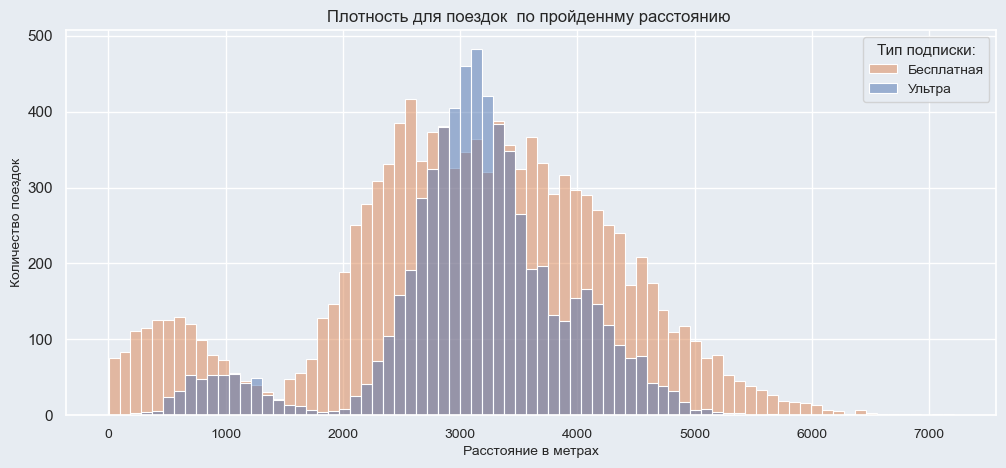

In [41]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12,5))
sns.histplot(data=data,  x='distance',  hue='subscription_type')
plt.title('Плотность для поездок  по пройденнму расстоянию ')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.legend(title='Тип подписки:',   labels=['Бесплатная','Ультра'],   title_fontsize=11,  fontsize=10,)
plt.xticks(fontsize=10)
plt.show()

- Распределние частоты пройденного расстояния для обеих групп похожи.Минимальное время поездки для пользователей с подпиской больше, чем для пользователей без неё.

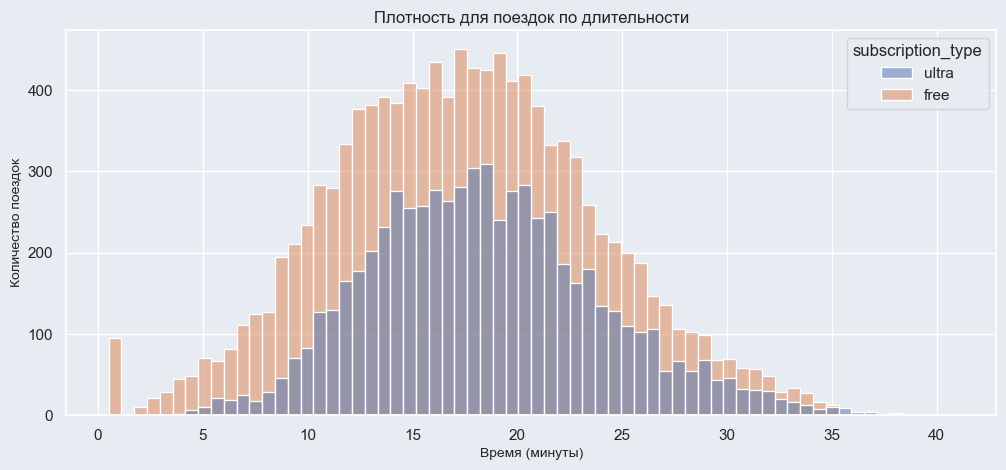

In [42]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12,5))
sns.histplot(data=data,  x='duration',  hue='subscription_type')
plt.title('Плотность для поездок по длительности')
plt.xlabel('Время (минуты)')
plt.ylabel('Количество поездок')
plt.show()

- Точно такой же вывод можно сделать и относительно затраченного на поездку времени.

## 5. Подсчёт выручки

Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя по месяцам.

In [43]:
# Округлим время поездки до верхнего целого числа в соотвествии с условиями тарификационной оплаты.
data.duration = np.ceil(data.duration)

In [44]:
users_total_revenue = data.pivot_table(
    index=('user_id', 'month'), 
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee'
    ), 
    aggfunc=({'distance':{'count', 'sum'}, 
             'duration':'sum',
             'minute_price': 'mean',
             'start_ride_price':'mean',
             'subscription_fee':'mean',})
)

users_total_revenue.columns = [
    'count', 'distance', 
    'duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee'
]


users_total_revenue.head()

count     distance  duration  minute_price  start_ride_price  \
user_id month                                                                 
1       1          2  7027.511294      42.0           6.0               0.0   
        4          1   754.159807       7.0           6.0               0.0   
        8          2  6723.470560      46.0           6.0               0.0   
        10         2  5809.911100      32.0           6.0               0.0   
        11         3  7003.499363      56.0           6.0               0.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0

In [45]:
users_total_revenue['revenue'] = (
users_total_revenue['start_ride_price']*users_total_revenue['count']+
users_total_revenue['minute_price']*users_total_revenue['duration']+
users_total_revenue['subscription_fee'])


print ('Выручка за 2021 год составила :',round(users_total_revenue['revenue'].sum(),2), 'руб.')

Выручка за 2021 год составила : 3878641.0 руб.


## Шаг 6. Проверка гипотез

**6.1** Узнаем  тратят ли пользователи с подпиской больше времени на поездки?

- H0: Средняя продолжительность поездки с ultra равна продолжительности поездки с без подписок.
- H1: Средняя продолжительность поездок с ultra больше продолжительности поездок без подписок.

- Установим уровень статистической значимости  в 5% и примененим  тест для двух независимых выборок. 

In [46]:
results = st.ttest_ind(data_ultra['duration'],data_free['duration'],alternative='greater')
print(results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


**6.2** Проверим среднее время поездки на самокатах для пользователей с подпиской и соотвествие оптимальному относительно критерию износа. - Расстояние поездки 3130 метров — оптимальное с точки зрения износа самоката. - Проверим проезжают ли в среднем пользователи с подпиской за одну поездку более этого значения.

Выдвинем гипотезы:

- Н0: Среднее расстояние поездок с подпиской ultra равно 3130 метрам.
- Н1: Среднее расстояние поездок с подпиской ultra больше 3130 метров.

Проверим это используя t-test для одной выборки.

In [47]:
distance = 3130
results = st.ttest_1samp(
    data_ultra['distance'], 
    distance,
    alternative='greater')


alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не удалось . Также можно сказать, что среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстоянием в 3130 метров.

**6.3**. Определим, будет ли ежемесячная выручка у пользователей с подпиской больше , чем выручка у пользователей без подписки.

Выдвинем гипотезы:

- Н0: Ежемесячная средняя выручка у пользователей с подпиской равна ежемесячной средней выручке у пользователей без подписки.
- Н1: Ежемесячная средняя выручка у пользователей с подпиской больше ежемесячной средней выручки у пользователей без подписки.

- Установим уровень статистической значимости  в 5% и примененим  тест для двух независимых выборок. 

In [48]:
results = st.ttest_ind(
    users_total_revenue.loc[users_total_revenue['subscription_fee'] > 0, 'revenue'], 
    users_total_revenue.loc[users_total_revenue['subscription_fee'] == 0, 'revenue'], 
    alternative='greater')
print(results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута и можно утверждать,что при установленном уровне статистической значимости, средняя месячная выручка у пользователей с подпиской, больше средней месячной выручки у пользователей без подписки.

**Общий вывод**


В процессе исследования данных о пользователях популярного сервиса аренды самокатов 'GoFast', были выполнены следующие этапы и сделаны выводы:

*Исследовательский анализ данных*

- Услугами сервиса аренды самокатов пользуются больше в городах с длинным климатическим летом. Исключение составил город Екатеринбург.

- Количество пользователей без подписки free 54,4% превышает количество пользователей с подпиской ultra 45,6%.

- Количества пользователей в зависимости от возраста указывает, что средний возраст потребителя услуги подчиняется нормальному распределению с медианой примерно в 25 лет, при этом средний возраст и медиана практически совпадают.

- Количество поездок в зависимости от расстояния имеет медиану 3133 метров, первый квартиль находится на значении 2543 метра, третий квартиль на 3776 метров. График имеет нормальное распределение с небольшим вторым пиком в районе 700 метров, который также  распределён еормально. Видимо эти два центра набора данных зависят от цели поездки. Первый, с пиком в 700 метров, для недалёких поездок: до магазина, метро. Второй для более длительных прогулок.

- Количество поездок в зависимости от продолжительности имеет медиану в 18 мин первый квартиль находится на значении 14 мин, третий квартиль на 22 мин. В колонке distance есть 95 аномальных значений, где время аренды самоката(0.5 минуты) не соотвествует пройденной дистанции.Поскольку пользователи платят за время, на этот технический момент стоит обратить внмание , чтобы избежать ненужных убытков.

*Подсчёт выручки*

- Выручка сервиса аренды самокатов "GoFast" за год составила 3 878 641.0.0 руб.

*Проверка гипотез*

- При установлннном уровне статистической значимости 5% и применении двухвыборочного теста нулевая гипотеза отвергается в пользу альтернативной.

- Нулевую гипотезу отвергнуть не удалось . Также можно сказать, что среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстоянием в 3130 метров.

- Нулевая гипотеза отвергнута и можно утверждать,что при установленном уровне статистической значимости, средняя месячная выручка у пользователей с подпиской, больше средней месячной выручки у пользователей без подписки.

Чтобы сравнить разницу между количеством обращений до технического обновления сервиса и после, мы должны использовать t-критерий для парных выборок, потому что первую выборку можно сопоставить со второй. Для этого мы будем использовать функцию ttest_rel(), для проведения t-теста парных выборок, который использует следующий синтаксис: ttest_rel(a, b), где а - массив наблюдений до, а б - после технического обновления. В нашем случае нас интересует снизилось ли количество обращений в результате обновления, по этому в качестве дополнительного параментра мы укажем 'less'.

*Советы для бизнеса*
- Постараться увеличить количество клиентов с платной подпиской, например, можно использовать различные промоакции или добавить в подписку скидку на сторонние услуги, в партнерстве с каким нибудь другим сервисом. Таким образом получится увеличить как общую прибыль, так и легче прогнозировать будущую выручку.
- Стоит подумать над оптимизацией количества ремонтов и замены самокатов, немного снизить их количество.
- Подумать над разработкой сетки из нескольких подписок, например, подписку по категориям: для студентов или семейную на несколько человек, или по фиксированным значениям времени и расстояния поездок.
- Проанализировать и выявить наиболее частые точки притяжения людей, оптимизировать количество самокатах на разных стоянках, в зависимости от средней загруженности локации.